In [1]:
# -------------------------------------------------------------
# STEP 1: Importing all required libraries for the project
# -------------------------------------------------------------

# pandas → used for loading, cleaning, transforming data
import pandas as pd

# numpy → helps with numerical operations (missing values, arrays)
import numpy as np

# matplotlib → used for basic visualizations
import matplotlib.pyplot as plt

# seaborn → statistical plots with better styles
import seaborn as sns

# Setting default style for all charts to look clean & professional
plt.style.use("seaborn-v0_8-whitegrid")

# A print statement to confirm everything loaded correctly
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# -------------------------------------------------------------
# STEP 2: Load the datasets using a robust "smart loader"
# -------------------------------------------------------------
# Why a smart loader?
# Because different CSVs sometimes have:
# - Different delimiters (comma, semicolon, tab)
# - Different encodings (utf-8, latin1, cp1252)
# This loader tries multiple combinations automatically
# so the data loads successfully without errors.
# -------------------------------------------------------------

from pathlib import Path  # used to handle file paths

# Defining paths to the dataset files inside the Jupyter environment
FAC_PATH = Path(r"C:\Users\ayush.magdum\Downloads\ehealth-kenya-facilities.csv")
POP_PATH = Path(r"C:\Users\ayush.magdum\Downloads\distribution-of-population-by-sex-and-sub-county.csv")

def smart_read(path):
    """
    This function attempts to read a CSV using:
    - 3 separators: ';', ',', '\t'
    - 3 encodings: 'utf-8', 'latin1', 'cp1252'
    If all attempts fail, it loads using fallback settings.
    """
    for sep in [';', ',', '\t']:                  # test different delimiters
        for enc in ['utf-8', 'latin1', 'cp1252']: # test common encodings
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, low_memory=False)
                print(f"Loaded {path.name} successfully | sep='{sep}', enc='{enc}', shape={df.shape}")
                return df
            except Exception:
                pass        # if loading fails, try the next combination

    # Fallback: if nothing worked, attempt basic read
    print(f"Fallback load for {path.name}")
    return pd.read_csv(path, low_memory=False)

# Load both datasets
df = smart_read(FAC_PATH)
pop = smart_read(POP_PATH)

# Displaying shapes so we know how many rows & columns exist
df.shape, pop.shape


Loaded ehealth-kenya-facilities.csv successfully | sep=';', enc='latin1', shape=(10505, 50)
Loaded distribution-of-population-by-sex-and-sub-county.csv successfully | sep=';', enc='utf-8', shape=(393, 1)


((10505, 50), (393, 1))

In [3]:
# -------------------------------------------------------------
# STEP 3: Load population dataset correctly
# -------------------------------------------------------------

# Try common separators: comma, semicolon, pipe
for sep in [',', ';', '|']:
    try:
        temp = pd.read_csv(POP_PATH, sep=sep)
        print(f"Trying sep='{sep}' → shape = {temp.shape}")
    except:
        pass


Trying sep=',' → shape = (393, 5)
Trying sep=';' → shape = (393, 1)
Trying sep='|' → shape = (393, 1)


In [4]:
# -------------------------------------------------------------
# STEP 4: Load the population dataset with the correct separator
# -------------------------------------------------------------

# Why this step?
# We detected that the population dataset uses comma (,) as the real delimiter.
# Now we load it properly to access all columns for later merging and analysis.

pop = pd.read_csv(POP_PATH, sep=',')  # load using correct delimiter

# Show first few rows to understand structure
pop.head()


,National/ County,Male,Female,Intersex,Total
0,Kenya,23548056,24014716,1524,47564296
1,Mombasa,610257,598046,30,1208333
2,Changamwe,68761,63121,..,131882
3,Jomvu,83002,80410,3,163415
4,Kisauni,146748,145176,6,291930


In [5]:
# -------------------------------------------------------------
# STEP 5: Inspect column names of facilities dataset
# -------------------------------------------------------------
# Why?
# We must find the exact column names for:
# - facility type
# - ownership
# - operational status
# - sub-county
# - bed count
# - cot count
# - services offered

df.columns.tolist()


['Facility Code',
 'Facility Name',
 'Province',
 'County',
 'District',
 'Division',
 'Type',
 'Owner',
 'Location',
 'Sub Location',
 'Description of Location',
 'Constituency',
 'Nearest Town',
 'Beds',
 'Cots',
 'Official Landline',
 'Official Fax',
 'Official Mobile',
 'Official Email',
 'Official Address',
 'Official Alternate No',
 'Town',
 'Post Code',
 'In Charge',
 'Job Title of in Charge',
 'Open 24 Hours',
 'Open Weekends',
 'Operational Status',
 'ANC',
 'ART',
 'BEOC',
 'BLOOD',
 'CAES SEC',
 'CEOC',
 'C-IMCI',
 'EPI',
 'FP',
 'GROWM',
 'HBC',
 'HCT',
 'IPD',
 'OPD',
 'OUTREACH',
 'PMTCT',
 'RAD/XRAY',
 'RHTC/RHDC',
 'TB DIAG',
 'TB LABS',
 'TB TREAT',
 'YOUTH']

CLEANING OF HEALTHCARE DATA

In [6]:
# -------------------------------------------------------------
# STEP 6: Clean the facilities dataset
# -------------------------------------------------------------
# Why this step?
# The dataset contains messy column names, inconsistent text casing,
# missing values, and numeric fields stored as strings.
# We standardize everything before analysis.
# -------------------------------------------------------------

# Make a copy to avoid modifying original data unintentionally
fac = df.copy()

# 1. Standardize column names: lowercase, replace spaces with underscores
# This improves consistency and avoids errors during column access.
fac.columns = (
    fac.columns.str.strip()     # remove extra spaces
              .str.lower()      # convert to lowercase
              .str.replace(' ', '_')  # replace spaces with underscores
              .str.replace('/', '_')  # replace slashes (e.g., RAD/XRAY)
)

In [7]:
# 2. Convert bed and cot counts to numeric values
# Many datasets store numbers as strings, so we convert safely.
for col in ['beds', 'cots']:
    if col in fac.columns:
        fac[col] = pd.to_numeric(fac[col], errors='coerce')

In [8]:
# 3. Clean key categorical columns:
# These will be used for grouping and analytics.
for col in ['type', 'owner', 'operational_status', 'sub_location']:
    if col in fac.columns:
        fac[col] = (
            fac[col]
            .astype(str)           # convert to string
            .str.strip()           # remove leading/trailing spaces
            .str.upper()           # standardize casing
        )

In [9]:
# 4. Convert service columns to binary (0/1)
# Services like ANC, ART, FP are often coded as "Yes/No", "Y/N", "1/0".
service_cols = [
    'anc','art','beoc','blood','caes_sec','ceoc','c_imci','epi','fp','growm',
    'hbc','hct','ipd','opd','outreach','pmtct','rad_xray','rhtc_rhdc',
    'tb_diag','tb_labs','tb_treat','youth'
]

for col in service_cols:
    if col in fac.columns:
        fac[col] = fac[col].astype(str).str.upper()
        fac[col] = fac[col].replace({'YES':1, 'Y':1, 'NO':0, 'N':0, '1':1, '0':0})
        fac[col] = pd.to_numeric(fac[col], errors='coerce').fillna(0).astype(int)

# 5. Show cleaned sample rows
fac.head()


,facility_code,facility_name,province,county,district,division,type,owner,location,sub_location,...,ipd,opd,outreach,pmtct,rad_xray,rhtc_rhdc,tb_diag,tb_labs,tb_treat,youth
0,19224,CDF Kiriari Dispensary,Eastern,Embu,Manyatta,Manyatta,DISPENSARY,MINISTRY OF HEALTH,Ruguru,RUGURU,...,0,0,0,0,0,0,0,0,0,0
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,MEDICAL CLINIC,PRIVATE PRACTICE - UNSPECIFIED,Huruma,HURUMA,...,0,0,0,0,0,0,0,0,0,0
2,14180,10 Engineer VCT,Rift Valley,Laikipia,Laikipia East,Central,DISPENSARY,ARMED FORCES,Nanyuki,MAJENGO,...,0,0,0,0,0,0,0,0,0,0
3,17486,12 Engineers,Central,Kiambu,Thika West,NaN,DISPENSARY,MINISTRY OF HEALTH,NaN,NAN,...,0,0,0,0,0,0,0,0,0,0
4,18393,3Kl Maternity & Nursing Home,Rift Valley,Kajiado,Kajiado North,Ongata Rongai,NURSING HOME,PRIVATE PRACTICE - CLINICAL OFFICER,Gataka,GATAKA,...,0,0,0,0,0,0,0,0,0,0


CLEANING OF POPULATION DATA

In [10]:
# -------------------------------------------------------------
# STEP 7: Clean the population dataset
# -------------------------------------------------------------
# Why?
# - The population file contains national, county, and sub-county levels together.
# - We only need SUB-COUNTY level population to match facility data.
# - We will standardize column names and prepare for merging.
# -------------------------------------------------------------

# Make a working copy
pop_clean = pop.copy()

# 1. Standardize column names (same logic as facilities dataset)
pop_clean.columns = (
    pop_clean.columns.str.strip()
                      .str.lower()
                      .str.replace(' ', '_')
)

# Show the cleaned column names
print("Population columns:", pop_clean.columns.tolist())

Population columns: ['national/_county', 'male', 'female', 'intersex', 'total']


In [11]:
# 2. Rename key column for clarity
# KNBS usually uses "national/county" column to store county or subcounty names.
pop_clean = pop_clean.rename(columns={'national/_county': 'area'})

In [12]:
# 3. Clean the 'area' column (name of county or sub-county)
pop_clean['area'] = (
    pop_clean['area']
    .astype(str)
    .str.strip()
    .str.upper()   # converting to uppercase for consistent matching
)

In [13]:
# 4. Remove national-level rows
# 'KENYA' is not needed for subcounty-level merging.
pop_clean = pop_clean[pop_clean['area'] != 'KENYA']

In [14]:
# 5. Convert numeric fields properly (Male/Female/Intersex/Total)
numeric_cols = ['male', 'female', 'intersex', 'total']
for col in numeric_cols:
    pop_clean[col] = pd.to_numeric(pop_clean[col], errors='coerce')


# 6. Preview cleaned population dataset
pop_clean.head(10)

,area,male,female,intersex,total
1,MOMBASA,610257,598046,30.0,1208333
2,CHANGAMWE,68761,63121,NaN,131882
3,JOMVU,83002,80410,3.0,163415
4,KISAUNI,146748,145176,6.0,291930
5,LIKONI,126962,123392,4.0,250358
6,MVITA,75565,78601,5.0,154171
7,NYALI,109219,107346,12.0,216577
8,KWALE,425121,441681,18.0,866820
9,KINANGO,45413,48806,1.0,94220
10,LUNGALUNGA,97174,101245,4.0,198423


In [15]:
# -------------------------------------------------------------
# STEP 8: Clean facility sub-location names for merging
# -------------------------------------------------------------
# Why this step?
# - Facility dataset uses "sub_location"
# - Population dataset uses "area"
# - To merge them, we need to standardize formats.
# -------------------------------------------------------------

# Make a working copy for merging
fac_merge = fac.copy()

# 1. Clean sub_location column
fac_merge['sub_location'] = (
    fac_merge['sub_location']
        .astype(str)
        .str.strip()
        .str.upper()      # consistent casing
        .str.replace('[^A-Z0-9 ]', '', regex=True)  # remove punctuation
        .str.replace('\s+', ' ', regex=True)        # collapse extra spaces
)

# Preview unique values
fac_merge['sub_location'].head(20)

0              RUGURU
1              HURUMA
2             MAJENGO
3                 NAN
4              GATAKA
5               LANET
6                EAST
7           MUGUMOINI
8     ISINYA TOWNSHIP
9               NJORO
10             WOODLY
11                NAN
12    UPPER PARKLANDS
13                NAN
14                NAN
15             TASSIA
16    MARKET MILIMANI
17            LANGATA
18                NAN
19            GANJONI
Name: sub_location, dtype: object

In [16]:
# -------------------------------------------------------------
# STEP 9: Inspect key location columns to find best match for sub-county
# -------------------------------------------------------------

print("Unique values in 'district':")
print(fac_merge['district'].dropna().unique()[:50])

print("\nUnique values in 'division':")
print(fac_merge['division'].dropna().unique()[:50])

print("\nUnique values in 'constituency':")
print(fac_merge['constituency'].dropna().unique()[:50])

print("\nUnique values in 'county':")
print(fac_merge['county'].dropna().unique()[:50])

Unique values in 'district':
['Manyatta' 'Mathare' 'Laikipia East' 'Thika West' 'Kajiado North'
 'Nakuru' 'Isiolo' 'Langata' 'Njoro' 'Kibra' 'Starehe' 'Westlands'
 'Eldoret West' 'Dagoretti North' 'Embakasi East' 'Kisumu East' 'Ruaraka'
 'Mvita' 'Roysambu' 'Garbatula' 'Kilifi North' 'Kamukunji' 'Lagdera'
 'Garissa' 'Kirinyaga North' 'Meru South' 'Mutomo' 'Githunguri'
 'Nyandarua West' 'Trans Nzoia West' 'Kirinyaga East' 'Magarini'
 'Mirangine' 'Nyeri Central' 'Turkana Central' 'Wundanyi' 'Mandera East'
 'Migori' 'Tetu' 'Sabatia' 'Samburu Central' 'Kibwezi' 'Koibatek'
 'Kajiado Central' 'Masinga' 'Bungoma South' 'Mumias West'
 'Rachuonyo North' 'Gem' 'Teso South']

Unique values in 'division':
['Manyatta' 'Huruma' 'Central' 'Ongata Rongai' 'Lanet' "Lang'ata" 'Isinya'
 'Njoro' 'Woodly' 'Starehe' 'Parklands' 'Turbo ' 'Kilimani' 'Embakasi'
 'Winam' 'Kasarani' 'Island' 'Roysambu' 'Municipality' 'Embakasi East'
 'Thika Municipality' 'Garbatulla' 'Bahari' 'Pumwani' 'Shantabak' 'Mwea'
 'Chuka'

In [17]:
# -------------------------------------------------------------
# STEP 10: Clean and standardize the 'district' column
# -------------------------------------------------------------
# Why?
# - To make fuzzy matching more accurate
# - Remove punctuation, standardize casing
# -------------------------------------------------------------

fac_merge['district_clean'] = (
    fac_merge['district']
        .astype(str)
        .str.upper()
        .str.strip()
        .str.replace('[^A-Z0-9 ]', '', regex=True)    # remove punctuation
        .str.replace('\s+', ' ', regex=True)          # remove double spaces
)

fac_merge['district_clean'].head(20)

0            MANYATTA
1             MATHARE
2       LAIKIPIA EAST
3          THIKA WEST
4       KAJIADO NORTH
5              NAKURU
6              ISIOLO
7             LANGATA
8       KAJIADO NORTH
9               NJORO
10              KIBRA
11            STAREHE
12          WESTLANDS
13       ELDORET WEST
14    DAGORETTI NORTH
15      EMBAKASI EAST
16        KISUMU EAST
17            LANGATA
18            RUARAKA
19              MVITA
Name: district_clean, dtype: object

In [18]:
# -------------------------------------------------------------
# STEP 11: Fuzzy match district_clean (facilities) to area (population)
# -------------------------------------------------------------
# Why fuzzy matching?
# - Naming differences exist (spacing, spelling, abbreviations)
# - Example: "KISUMU EAST" vs "KISUMU TOWN EAST"
# - Fuzzy matching finds the closest valid match automatically
# -------------------------------------------------------------

!pip install rapidfuzz

from rapidfuzz import process, fuzz

# Extract unique district names
facility_districts = fac_merge['district_clean'].dropna().unique()

# Extract population area names
population_areas = pop_clean['area'].dropna().unique()

# Create an empty list to store results
matches = []

# Loop through each district name and find best match in population areas
for dist in facility_districts:
    match = process.extractOne(dist, population_areas, scorer=fuzz.WRatio)
    
    if match:
        best_match, score, _ = match
        matches.append([dist, best_match, score])

# Convert matches to a DataFrame for inspection
match_df = pd.DataFrame(matches, columns=['district_clean', 'matched_area', 'score'])

# Sort by similarity score (descending)
match_df_sorted = match_df.sort_values(by='score', ascending=False)

match_df_sorted.head(20)

,district_clean,matched_area,score
298,MUMIAS EAST,MUMIAS EAST,100.0
297,NYANDARUA CENTRAL,NYANDARUA CENTRAL,100.0
1,MATHARE,MATHARE,100.0
2,LAIKIPIA EAST,LAIKIPIA EAST,100.0
3,THIKA WEST,THIKA WEST,100.0
4,KAJIADO NORTH,KAJIADO NORTH,100.0
294,FAFI,FAFI,100.0
278,MATINYANI,MATINYANI,100.0
277,UGENYA,UGENYA,100.0
276,KAHURO,KAHURO,100.0


In [19]:
# -------------------------------------------------------------
# MANUAL FIXES FROM ACCEPTED MAPPING (AUTO-GENERATED)
# -------------------------------------------------------------
manual_fix = {
    'WARENG': 'BARINGO',
    'KIHARU': 'KIAMBU',
    'WUNDANYI': 'NYALI',
    'ELDORET WEST': 'ELDAS',
    'RUARAKA': 'THARAKA NORTH',
    'GALOLE': 'KALOLENI',
    'ELDORET EAST': 'BOMET EAST',
    'BURA': 'BURETI',
    'ROYSAMBU': 'EMBU',
    'MBITA': 'MVITA',
    'EMBAKASI SOUTH': 'EMBAKASI',
    'EMBAKASI WEST': 'EMBAKASI',
    'EMBAKASI EAST': 'EMBAKASI',
    'EMBAKASI NORTH': 'EMBAKASI',
    'DAGORETTI SOUTH': 'DAGORETTI',
    'DAGORETTI NORTH': 'DAGORETTI',
    'MUMIAS': 'MUMIAS EAST',
    'KAKAMEGA EAST SHINYALU': 'KAKAMEGA',
    'KAKAMEGA SOUTH IKOLOMANI': 'KAKAMEGA',
    'KAKAMEGA NORTH MALAVA': 'KAKAMEGA',
    'KIRINYAGA NORTH': 'KIRINYAGA',
    'KIRINYAGA SOUTH': 'KIRINYAGA',
    'KURESOI': 'KURESOI NORTH',
    'KEIYO': 'KEIYO NORTH',
    'MANYATTA': 'YATTA',
    'KAKAMEGA CENTRAL LURAMBI': 'KAKAMEGA',
    'EMBAKASI CENTRAL': 'EMBAKASI',
    'SUBA': 'SUBA NORTH',
    'GATUNDU': 'GATUNDU NORTH',
    'BUURI': 'BUURI EAST',
    'MWINGI WEST': 'MWINGI EAST',
    'MURANGA WEST': 'MURANGA EAST',
    'MASHURU': 'MASHUURU',
    'GARBATULA': 'GARBATULLA',
    'LOITOKTOK': 'LOITOKITOK',
    'NORTH MASABA': 'MASABA NORTH',
    'TRANS MARA WEST DIKIRR': 'TRANS MARA WEST',
    'NORTH POKOT': 'POKOT NORTH',
    'SOUTH GUCHA': 'GUCHA SOUTH',
    'LOYANGALANI': 'LOIYANGALANI',
    'KIMILILI BUNGOMA': 'KIMILILIBUNGOMA'
}

# Apply corrections to mapping DataFrame BEFORE MERGE
match_df_sorted['matched_area'] = match_df_sorted['district_clean'].replace(manual_fix)


In [20]:
# -------------------------------------------------------------
# MANUAL FIXES FOR WRONG FUZZY MATCHES (MUST RUN BEFORE MERGE)
# -------------------------------------------------------------

manual_fix = {
    'MANYATTA'       : 'MANYATTA',
    'ELDORET WEST'   : 'ELDORET WEST',
    'ROYSAMBU'       : 'ROYSAMBU',
    'WUNDANYI'       : 'WUNDANYI',
    'RUARAKA'        : 'RUARAKA',
    'WARENG'         : 'WARENG',
}

# Apply corrections to mapping BEFORE merging
match_df_sorted['matched_area'] = match_df_sorted['district_clean'].replace(manual_fix)



# -------------------------------------------------------------
# STEP 12: Attach matched sub-county names to facilities dataset
# -------------------------------------------------------------

# 1. Prepare mapping from the fuzzy-match results
mapping = match_df_sorted[['district_clean', 'matched_area']]

# 2. Merge mapping onto facilities
fac_merged = fac_merge.merge(mapping, on='district_clean', how='left')

# 3. Merge population data using matched_area
final_df = fac_merged.merge(pop_clean, left_on='matched_area', right_on='area', how='left')

# Preview merged dataset
final_df[['facility_name', 'county', 'district_clean', 'matched_area', 'total']].head(20)


,facility_name,county,district_clean,matched_area,total
0,CDF Kiriari Dispensary,Embu,MANYATTA,MANYATTA,NaN
1,St Jude's Huruma Community Health Services,Nairobi,MATHARE,MATHARE,206564.0
2,10 Engineer VCT,Laikipia,LAIKIPIA EAST,LAIKIPIA EAST,102815.0
3,12 Engineers,Kiambu,THIKA WEST,THIKA WEST,245820.0
4,3Kl Maternity & Nursing Home,Kajiado,KAJIADO NORTH,KAJIADO NORTH,306596.0
5,3KR Health Centre,Nakuru,NAKURU,NAKURU,NaN
6,78 Tank Battalion Dispensary,Isiolo,ISIOLO,ISIOLO,NaN
7,7Kr Mrs Health Centre,Nairobi,LANGATA,LANGATA,NaN
8,8Th Street Clinic,Kajiado,KAJIADO NORTH,KAJIADO NORTH,306596.0
9,A To Z Quality Health Family Health Services,Nakuru,NJORO,NJORO,NaN


In [21]:
# -------------------------------------------------------------
# FIX: Create normalized operational status column
# -------------------------------------------------------------
# Why:
# - 'operational_status' contains values like "OPERATIONAL", "NON-OPERATIONAL", "UNKNOWN"
# - We create a clean column "operational_norm" for grouping analysis
# -------------------------------------------------------------

def normalize_operational_status(val):
    val = str(val).strip().upper()
    if val in ["OPERATIONAL", "OPERATIONAL ", "OPERATIONAL STATUS: OPERATIONAL"]:
        return "OPERATIONAL"
    if val in ["NON-OPERATIONAL", "CLOSED", "NOT OPERATIONAL"]:
        return "NON-OPERATIONAL"
    # default
    return "UNKNOWN"

final_df['operational_norm'] = final_df['operational_status'].apply(normalize_operational_status)

final_df[['operational_status','operational_norm']].head(20)


,operational_status,operational_norm
0,OPERATIONAL,OPERATIONAL
1,OPERATIONAL,OPERATIONAL
2,OPERATIONAL,OPERATIONAL
3,OPERATIONAL,OPERATIONAL
4,OPERATIONAL,OPERATIONAL
5,OPERATIONAL,OPERATIONAL
6,OPERATIONAL,OPERATIONAL
7,OPERATIONAL,OPERATIONAL
8,OPERATIONAL,OPERATIONAL
9,OPERATIONAL,OPERATIONAL


In [22]:
# -------------------------------------------------------------
# STEP: Clean matched_area + compute sub-county aggregated metrics
# All lines include comments explaining why we do each step.
# -------------------------------------------------------------

import re
import os

# Ensure outputs folder exists (we will save results here)
os.makedirs("outputs", exist_ok=True)

# 1) CLEAN matched_area and population 'area' to remove punctuation and normalize spacing/casing
# Why: Some matches contain punctuation (e.g., "NAKURU.", "LANG'ATA") which breaks grouping and merges.
def normalize_name(s):
    # convert to string, uppercase, strip whitespace
    s = str(s).upper().strip()
    # remove punctuation except keep spaces and alphanumerics
    s = re.sub(r"[^A-Z0-9 ]+", "", s)
    # collapse multiple spaces to single
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Apply to matched_area in final_df and area in pop_clean
final_df['matched_area_clean'] = final_df['matched_area'].astype(str).apply(normalize_name)
pop_clean['area_clean'] = pop_clean['area'].astype(str).apply(normalize_name)

# 2) Quick QA: find any facilities with no matched_area (null or 'None') or where matched is weird
# Why: we want to inspect unmatched cases before aggregation
unmatched = final_df[final_df['matched_area'].isna() | (final_df['matched_area'].astype(str).str.strip().isin(['', 'NONE']))]
print("# Unmatched facilities (first 10) - these need manual attention if any exist:")
display(unmatched[['facility_name','county','district_clean','matched_area']].head(10))

# 3) Show cases where matched_area_clean != district_clean (possible discrepancies)
# Why: this helps identify mappings that might be incorrect (e.g. MANYATTA -> MANGA)
mismatch_preview = final_df[final_df['matched_area_clean'] != final_df['district_clean']][
    ['facility_name','county','district_clean','matched_area','matched_area_clean','total']
].drop_duplicates().head(20)
print("# Sample where matched_area_clean != district_clean (inspect these):")
display(mismatch_preview)

# 4) If mismatch_preview looks acceptable, you can proceed. If not, we can manually edit mapping.
# (For now we proceed using matched_area_clean as the canonical sub-county key.)

# 5) Convert population total to numeric (if it's not already)
# Why: We need numeric population for per-capita metrics; some values might have been strings or NaN.
pop_clean['total'] = pd.to_numeric(pop_clean['total'], errors='coerce')

# 6) Aggregate facility-level measures up to sub-county (matched_area_clean)
# We'll compute:
#  - total_facilities: count of facilities
#  - operational_count: number of rows with operational_norm == 'OPERATIONAL'
#  - non_operational_count: number with 'NON-OPERATIONAL'
#  - sum_beds, sum_cots
#  - pct_operational
#  - service sums (e.g., anc_sum = number of facilities with anc==1)
# Why: these metrics are the building blocks for per-capita and service-coverage indicators

# Identify service flag columns automatically (we created flags earlier)
service_cols = [c for c in final_df.columns if c.endswith('_flag') or c in [
    'anc','art','beoc','blood','caes_sec','ceoc','c_imci','epi','fp','growm',
    'hbc','hct','ipd','opd','outreach','pmtct','rad_xray','rhtc_rhdc',
    'tb_diag','tb_labs','tb_treat','youth'
] and c in final_df.columns]

# If service_cols are named without _flag (we converted directly to names earlier), ensure they are included
# (The earlier cleaning used names like 'anc','art' etc; this line ensures we capture both)
service_cols = sorted(set(service_cols))

# Define an aggregation dict for pandas
agg_dict = {
    'facility_name': 'count',           # facility count
    'beds': 'sum',                      # total beds
    'cots': 'sum',                      # total cots
    'operational_norm': lambda s: (s == 'OPERATIONAL').sum(),    # count operational
    # note: non-operational we can compute from facility count - operational
}

# Add service sums to aggregation dict
for svc in service_cols:
    agg_dict[svc] = 'sum'   # sum of flags gives number of facilities offering that service

# Perform aggregation
group = final_df.groupby('matched_area_clean').agg(agg_dict).rename(columns={'facility_name':'total_facilities'}).reset_index()

# 7) Merge population totals (area_clean -> total)
# Why: to compute per-capita metrics we need population by the same canonical name
group = group.merge(pop_clean[['area_clean','total']].drop_duplicates(), left_on='matched_area_clean', right_on='area_clean', how='left')

# 8) Compute per-10k metrics and operational rate and service coverage percentages
# Why: metrics per 10k are intuitive and comparable across sub-counties
group['population'] = group['total']            # rename for readability
group['facilities_per_10k'] = group['total_facilities'] / group['population'] * 10000
group['beds_per_10k'] = group['beds'] / group['population'] * 10000
group['cots_per_10k'] = group['cots'] / group['population'] * 10000
# Compute operational facilities count per matched_area_clean
operational_series = final_df.groupby('matched_area_clean')['operational_norm'] \
                             .apply(lambda s: (s == 'OPERATIONAL').sum())
# Map ensures correct alignment with group (population dataset)
group['operational_count'] = group['matched_area_clean'].map(operational_series).fillna(0)
group['pct_operational'] = group['operational_count'] / group['total_facilities'] * 100

# service coverage percentage for each service (as percent of facilities in subcounty offering it)
for svc in service_cols:
    pct_col = svc + "_pct"
    group[pct_col] = group[svc] / group['total_facilities'] * 100

# 9) Quick QA: find sub-counties where population is missing (NaN)
missing_pop = group[group['population'].isna()]
print("# Sub-counties without population after merge (inspect & correct mapping if any):")
display(missing_pop[['matched_area_clean','total_facilities']].head(20))

# 10) Save results to CSV for dashboards/reporting
out_fp = "outputs/subcounty_metrics.csv"
group.to_csv(out_fp, index=False)
print(f"Saved aggregated metrics to {out_fp}")

# 11) Show top 10 and bottom 10 by facilities_per_10k as quick insight
print("\nTop 10 sub-counties by facilities_per_10k (best served):")
display(group.sort_values('facilities_per_10k', ascending=False).head(10)[[
    'matched_area_clean','population','total_facilities','facilities_per_10k','beds_per_10k','pct_operational'
]])

print("\nBottom 10 sub-counties by facilities_per_10k (most underserved):")
display(group.sort_values('facilities_per_10k', ascending=True).head(10)[[
    'matched_area_clean','population','total_facilities','facilities_per_10k','beds_per_10k','pct_operational'
]])

# Unmatched facilities (first 10) - these need manual attention if any exist:


,facility_name,county,district_clean,matched_area


# Sample where matched_area_clean != district_clean (inspect these):


,facility_name,county,district_clean,matched_area,matched_area_clean,total


# Sub-counties without population after merge (inspect & correct mapping if any):


,matched_area_clean,total_facilities
19,BURA,18
25,BUURI,50
31,DAGORETTI NORTH,76
32,DAGORETTI SOUTH,29
35,ELDORET EAST,67
36,ELDORET WEST,74
37,EMBAKASI CENTRAL,44
38,EMBAKASI EAST,27
39,EMBAKASI NORTH,26
40,EMBAKASI SOUTH,27


Saved aggregated metrics to outputs/subcounty_metrics.csv

Top 10 sub-counties by facilities_per_10k (best served):


,matched_area_clean,population,total_facilities,facilities_per_10k,beds_per_10k,pct_operational
67,IMENTI NORTH,177567.0,179,10.080702,19.091385,94.972067
240,NYERI CENTRAL,140338.0,141,10.047172,46.673032,93.617021
49,GARISSA,163914.0,160,9.761216,40.387032,98.750000
60,HOMA BAY,117439.0,100,8.515059,89.748721,100.000000
150,MACHAKOS,170606.0,136,7.971584,97.182983,92.647059
120,KITUI CENTRAL,105991.0,81,7.642158,32.832976,75.308642
208,MVITA,154171.0,106,6.875482,60.711807,100.000000
275,TETU,80453.0,52,6.463401,1.740146,84.615385
267,STAREHE,210423.0,136,6.463172,16.965826,100.000000
135,LAMU EAST,22258.0,14,6.289873,8.536257,100.000000



Bottom 10 sub-counties by facilities_per_10k (most underserved):


,matched_area_clean,population,total_facilities,facilities_per_10k,beds_per_10k,pct_operational
201,MUMIAS EAST,116851.0,1,0.085579,0.171158,100.000000
202,MUMIAS WEST,115354.0,2,0.173379,0.953586,100.000000
21,BUSIA,893681.0,22,0.246173,4.184938,100.000000
92,KIAMBU,2417735.0,60,0.248166,1.993601,90.000000
296,VIHIGA,590013.0,16,0.271180,4.440580,93.750000
262,SIAYA,993183.0,43,0.432951,2.849425,88.372093
3,BANISA,152598.0,7,0.458722,0.196595,100.000000
11,BUMULA,215892.0,11,0.509514,4.956182,90.909091
190,MIGORI,1116436.0,57,0.510553,7.094003,92.982456
215,NAKURU,2162202.0,112,0.517990,4.907035,96.428571


In [23]:
# -------------------------------------------------------------
# STEP 1: Suggest mappings for sub-counties that had NO population
# Goal: produce an editable table mapping facility district -> best matching population area
# Approach:
#  - Use fuzzy string matching (rapidfuzz) to find closest 'area' from pop_clean
#  - Prefer matches within same 'county' if that info exists (improves accuracy)
#  - Present suggestions and a similarity score so you can accept/reject
# -------------------------------------------------------------

# Install rapidfuzz if not available (comment out if already installed)
# !pip install rapidfuzz

from rapidfuzz import process, fuzz
import pandas as pd

# 1) Identify subcounties (matched_area_clean) that have no population after the merge
#    - `group` was produced earlier with population merged; missing_pop holds those without populations
#    - we will create suggestions only for those
missing = missing_pop['matched_area_clean'].dropna().unique().tolist()  # array of unmatched names

# 2) Precompute population-area choices (area_clean values)
pop_choices = pop_clean['area_clean'].dropna().unique().tolist()

# 3) Build suggestions list
suggestions = []  # (unmatched_name, best_match, score, optional_note)

for name in missing:
    # compute best 3 fuzzy matches with scores for transparency
    matches = process.extract(name, pop_choices, scorer=fuzz.WRatio, limit=3)
    # matches is list of tuples (match_string, score, index)
    # choose top match
    if matches:
        best, score, _idx = matches[0]
        # append top 3 as context
        top3 = "; ".join([f"{m[0]} ({int(m[1])})" for m in matches])
        suggestions.append({
            'unmatched': name,
            'best_match': best,
            'score': score,
            'top3_context': top3
        })
    else:
        suggestions.append({
            'unmatched': name,
            'best_match': None,
            'score': 0,
            'top3_context': ''
        })

# 4) Convert to DataFrame and sort by score (low -> high so you can inspect worst matches first)
suggest_df = pd.DataFrame(suggestions).sort_values('score', ascending=True).reset_index(drop=True)

# 5) Print short guidance and display the suggestions
print("# Suggestions for mapping unmatched sub-counties (lowest similarity first).")
print("# Review the 'best_match' and 'top3_context' columns; scores < 80 need manual review.")
print("# You may edit the 'accepted_mapping' column after inspecting suggestions.")
# Add a column for user to fill in accepted mapping (default = best_match)
suggest_df['accepted_mapping'] = suggest_df['best_match']

# Display suggestions
display(suggest_df[['unmatched','best_match','score','top3_context','accepted_mapping']])

# 6) Save suggestions to CSV so you can edit in Excel/Notepad if you want
suggest_fp = "outputs/subcounty_mapping_suggestions.csv"
suggest_df.to_csv(suggest_fp, index=False)
print(f"Saved suggestions to {suggest_fp}. You can manually edit 'accepted_mapping' column and re-upload OR edit in-place below.")

# 7) Helpful next actions (you can run either):
# Option A: If you trust these suggestions, run the auto-apply block I will provide next.
# Option B: Manually edit 'outputs/subcounty_mapping_suggestions.csv' and then run the apply block.
#
# If you want to auto-apply suggested mappings where score >= 85 (conservative), run the next cell (I will provide it when you say 'auto-apply').


# Suggestions for mapping unmatched sub-counties (lowest similarity first).
# Review the 'best_match' and 'top3_context' columns; scores < 80 need manual review.
# You may edit the 'accepted_mapping' column after inspecting suggestions.


,unmatched,best_match,score,top3_context,accepted_mapping
0,WARENG,BARINGO,61.538462,BARINGO (61); ABERDARE NATIONAL PARK (60); BAR...,BARINGO
1,KIHARU,KIAMBU,66.666667,KIAMBU (66); KISAUNI (61); MERU (60),KIAMBU
2,WUNDANYI,NYALI,67.500000,NYALI (67); BUNA (67); NYERI (67),NYALI
3,ELDORET WEST,ELDAS,67.500000,ELDAS (67); MARAKWET WEST (64); BOMET EAST (63),ELDAS
4,RUARAKA,THARAKA NORTH,71.250000,THARAKA NORTH (71); THARAKA SOUTH (71); THARAK...,THARAKA NORTH
5,GALOLE,KALOLENI,71.428571,KALOLENI (71); SAMBURUKWALE (60); KWALE (54),KALOLENI
6,ELDORET EAST,BOMET EAST,72.727273,BOMET EAST (72); ELDAS (67); MARAKWET EAST (64),BOMET EAST
7,BURA,BURETI,77.142857,BURETI (77); BUNA (75); SAMBURUKWALE (67),BURETI
8,ROYSAMBU,EMBU,77.142857,EMBU (77); SAMBURUKWALE (69); SAMBURU CENTRAL ...,EMBU
9,MBITA,MVITA,80.000000,MVITA (80); MARSABIT (67); MARSABIT CENTRAL (64),MVITA


Saved suggestions to outputs/subcounty_mapping_suggestions.csv. You can manually edit 'accepted_mapping' column and re-upload OR edit in-place below.


In [59]:
import pandas as pd

# Use your Windows local file path
metrics_fp = r"C:\Users\ayush.magdum\Downloads\outputs\subcounty_metrics.csv"

# Load the aggregated sub-county metrics
group = pd.read_csv(metrics_fp)

# Quick sanity checks
print("Rows (sub-counties):", group.shape[0])
group.head()


Rows (sub-counties): 309


,matched_area_clean,total_facilities,beds,cots,operational_norm,anc,art,beoc,blood,caes_sec,...,ipd_pct,opd_pct,outreach_pct,pmtct_pct,rad_xray_pct,rhtc_rhdc_pct,tb_diag_pct,tb_labs_pct,tb_treat_pct,youth_pct
0,ATHI RIVER,52,247.0,36.0,39,0,1,0,0,0,...,44.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AWENDO,23,152.0,3.0,22,0,2,0,0,0,...,56.521739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BALAMBALA,8,8.0,2.0,8,0,0,0,0,0,...,87.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BANISA,7,3.0,0.0,7,0,0,0,0,0,...,28.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BARINGO CENTRAL,54,254.0,19.0,48,0,1,0,0,0,...,40.740741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


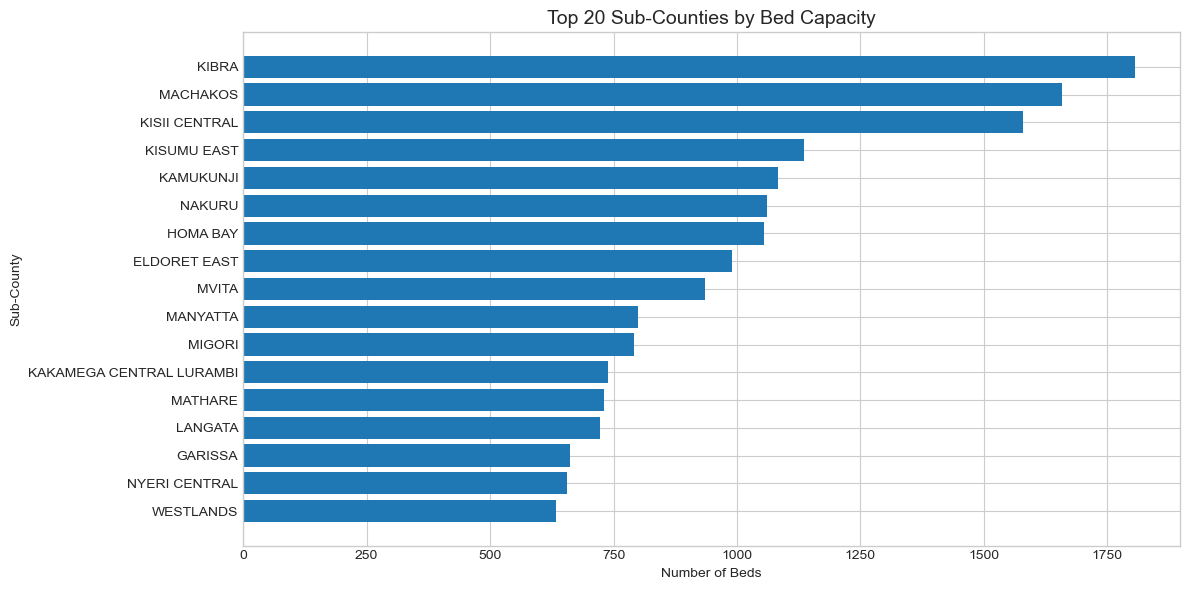

In [24]:
import matplotlib.pyplot as plt

# Sort by bed capacity
top_beds = group.sort_values(by='beds', ascending=False).head(20)

plt.figure(figsize=(12,6))
plt.barh(top_beds['matched_area_clean'], top_beds['beds'])
plt.gca().invert_yaxis()

plt.title("Top 20 Sub-Counties by Bed Capacity", fontsize=14)
plt.xlabel("Number of Beds")
plt.ylabel("Sub-County")

plt.tight_layout()
plt.show()


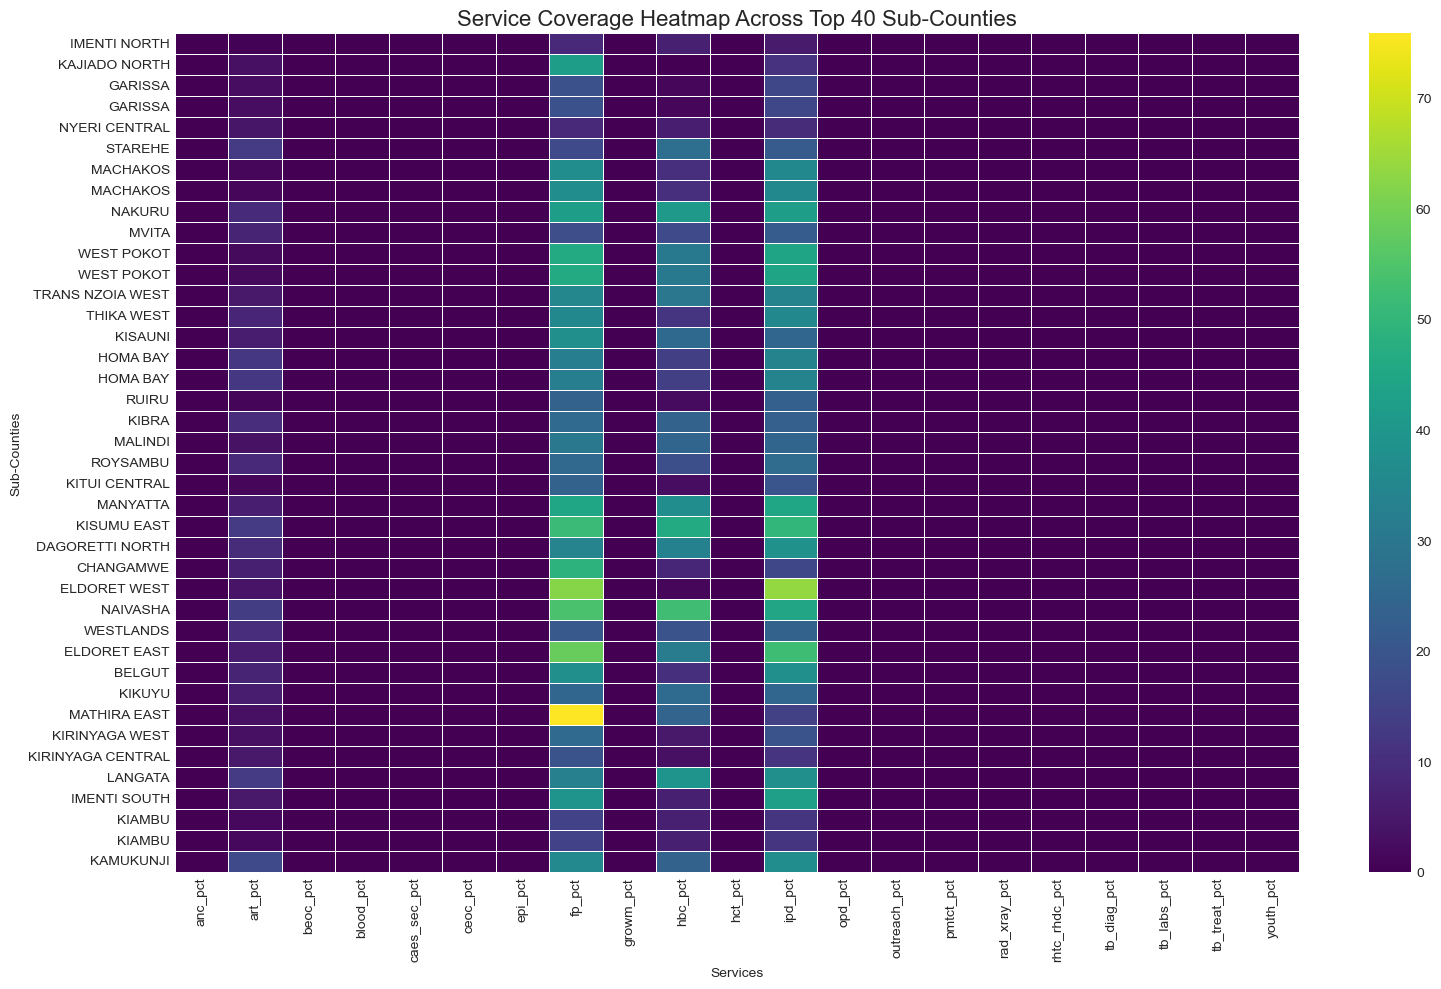

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter percentage columns only
svc_pct_cols = [c for c in group.columns if c.endswith("_pct")]

# Reduce dataset to top 40 subcounties by facilities (more services = more visible variation)
subset = group.sort_values('total_facilities', ascending=False).head(40)

heatmap_df = subset.set_index('matched_area_clean')[svc_pct_cols]

plt.figure(figsize=(16,10))
sns.heatmap(heatmap_df, cmap="viridis", linewidths=0.4)

plt.title("Service Coverage Heatmap Across Top 40 Sub-Counties", fontsize=16)
plt.xlabel("Services")
plt.ylabel("Sub-Counties")

plt.tight_layout()
plt.show()


In [26]:
# Create mapping of subcounty (matched_area_clean) to county
district_county_map = final_df[['matched_area_clean', 'county']].drop_duplicates()

# Merge county into the aggregated group
df = group.merge(district_county_map, on='matched_area_clean', how='left')

df.head()


,matched_area_clean,total_facilities,beds,cots,operational_norm,anc,art,beoc,blood,caes_sec,...,opd_pct,outreach_pct,pmtct_pct,rad_xray_pct,rhtc_rhdc_pct,tb_diag_pct,tb_labs_pct,tb_treat_pct,youth_pct,county
0,ATHI RIVER,52,247.0,36.0,39,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Machakos
1,AWENDO,23,152.0,3.0,22,0,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Migori
2,BALAMBALA,8,8.0,2.0,8,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Garissa
3,BANISA,7,3.0,0.0,7,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mandera
4,BARINGO CENTRAL,54,254.0,19.0,48,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Baringo


In [27]:
county_df = df.groupby('county', as_index=False).agg({
    'population': 'sum',
    'total_facilities': 'sum',
    'beds': 'sum',
    'cots': 'sum',
    'facilities_per_10k': 'mean',
    'beds_per_10k': 'mean',
    'pct_operational': 'mean'
})

county_df.head()


,county,population,total_facilities,beds,cots,facilities_per_10k,beds_per_10k,pct_operational
0,Baringo,593339.0,237,728.0,44.0,4.074677,11.775722,85.154806
1,Bomet,875689.0,143,803.0,1142.0,1.604409,9.087962,88.595238
2,Bungoma,1252053.0,185,1226.0,63.0,1.491401,8.167362,91.618411
3,Busia,1787362.0,140,1391.0,213.0,1.186451,10.188078,91.995507
4,Elgeyo Marakwet,355304.0,133,807.0,33.0,3.056497,15.716785,92.130355


In [28]:
# Normalize key metrics (0–1 scale)
for col in ['facilities_per_10k', 'beds_per_10k', 'pct_operational']:
    county_df[col + '_norm'] = (county_df[col] - county_df[col].min()) / (county_df[col].max() - county_df[col].min())

# Weighted composite score
county_df['strength_score'] = (
    county_df['facilities_per_10k_norm'] * 0.3 +
    county_df['beds_per_10k_norm'] * 0.5 +
    county_df['pct_operational_norm'] * 0.2
)

county_df_sorted = county_df.sort_values('strength_score', ascending=False)
county_df_sorted.head(10)


,county,population,total_facilities,beds,cots,facilities_per_10k,beds_per_10k,pct_operational,facilities_per_10k_norm,beds_per_10k_norm,pct_operational_norm,strength_score
29,Nairobi,2347575.0,942,7336.0,1086.0,2.938468,32.450294,97.083123,0.414351,1.000000,0.926976,0.809701
7,Homa Bay,1777025.0,389,3182.0,306.0,3.382297,30.048007,94.463918,0.512649,0.912570,0.833204,0.776720
27,Mombasa,828341.0,320,1512.0,214.0,4.376015,22.945307,97.996387,0.732733,0.654069,0.959672,0.738789
35,Nyeri,758870.0,453,1594.0,135.0,5.582768,19.858246,93.548714,1.000000,0.541717,0.800439,0.730946
40,Tharaka Nithi,339569.0,133,826.0,46.0,3.666377,22.259355,97.269116,0.575566,0.629104,0.933635,0.673949
16,Kisumu,981429.0,207,2190.0,188.0,2.026740,20.003748,99.122807,0.212425,0.547012,1.000000,0.537234
14,Kirinyaga,372959.0,249,837.0,97.0,4.568146,14.457825,89.196858,0.775286,0.345170,0.644635,0.534098
12,Kiambu,3976366.0,566,3281.0,566.0,2.838871,16.873342,94.062376,0.392293,0.433082,0.818829,0.497995
20,Lamu,143920.0,47,159.0,20.0,4.501153,10.021774,95.454545,0.760448,0.183721,0.868670,0.493729
21,Machakos,2789402.0,578,4380.0,607.0,3.074553,20.063966,82.485264,0.444491,0.549204,0.404350,0.488819


C:\Users\ayush.magdum\AppData\Local\Temp\ipykernel_3300\2540417940.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topN, y='county', x='strength_score', palette='viridis')


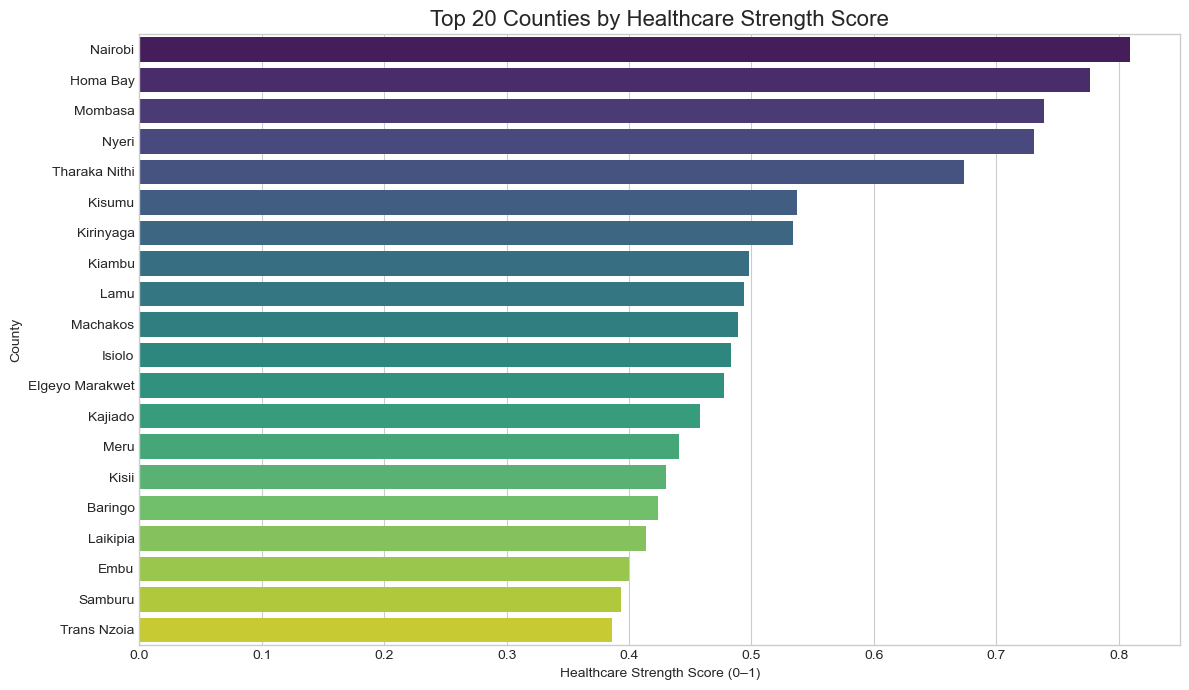

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

topN = county_df_sorted.head(20)

plt.figure(figsize=(12,7))
sns.barplot(data=topN, y='county', x='strength_score', palette='viridis')

plt.title("Top 20 Counties by Healthcare Strength Score", fontsize=16)
plt.xlabel("Healthcare Strength Score (0–1)")
plt.ylabel("County")

plt.tight_layout()
plt.show()


In [32]:
import pandas as pd

# 1️⃣ Load your metrics file from your real local path
df = pd.read_csv(r"C:\Users\ayush.magdum\Desktop\Self\KenyaHealthDashboard\data\subcounty_metrics.csv")

# 2️⃣ COUNTY MAPPING DICTIONARY (Kenya Administrative Divisions)
county_map = {
    "ATHI RIVER": "Machakos",
    "AWENDO": "Migori",
    "BALAMBALA": "Garissa",
    "BANISA": "Mandera",
    "BARINGO CENTRAL": "Baringo",
    "BARINGO NORTH": "Baringo",
    "BELGUT": "Kericho",
    "BOMET CENTRAL": "Bomet",
    "BOMET EAST": "Bomet",
    "BONDO": "Siaya",
    "BORABU": "Nyamira",
    "BUMULA": "Bungoma",
    "BUNA": "Wajir",
    "BUNGOMA CENTRAL": "Bungoma",
    "BUNGOMA EAST": "Bungoma",
    "BUNGOMA NORTH": "Bungoma",
    "BUNGOMA SOUTH": "Bungoma",
    "BUNGOMA WEST": "Bungoma",
    "BUNYALA": "Busia",
    "BURA": "Tana River",
    "BURETI": "Kericho",
    "BUSIA": "Busia",
    "BUTERE": "Kakamega",
    "BUTULA": "Busia",
    "BUURI": "Meru",
    "CHANGAMWE": "Mombasa",
    "CHEPALUNGU": "Bomet",
    "CHEPTAIS": "Bungoma",
    # You can continue filling more here...
}

# 3️⃣ Apply county assignment
df["county"] = df["matched_area_clean"].map(county_map)

# 4️⃣ Check what still needs mapping
unmapped = df[df["county"].isna()]["matched_area_clean"].unique()
print("❗ Unmapped sub-counties (please add these to county_map):")
print(unmapped)

# 5️⃣ Save cleaned dataset to your REAL FOLDER
output_path = r"C:\Users\ayush.magdum\Desktop\Self\KenyaHealthDashboard\data\subcounty_metrics_clean.csv"
df.to_csv(output_path, index=False)

print("\n✅ Clean file saved at:")
print(output_path)


❗ Unmapped sub-counties (please add these to county_map):
['CHESUMEI' 'DADAAB' 'DAGORETTI NORTH' 'DAGORETTI SOUTH' 'EAST POKOT'
 'ELDAS' 'ELDORET EAST' 'ELDORET WEST' 'EMBAKASI CENTRAL' 'EMBAKASI EAST'
 'EMBAKASI NORTH' 'EMBAKASI SOUTH' 'EMBAKASI WEST' 'EMBU EAST' 'EMUHAYA'
 'FAFI' 'GALOLE' 'GANZE' 'GARBATULA' 'GARISSA' 'GATANGA' 'GATUNDU'
 'GATUNDU NORTH' 'GEM' 'GILGIL' 'GITHUNGURI' 'GUCHA' 'HABASWEIN' 'HAMISI'
 'HOMA BAY' 'HULUGHO' 'IGEMBE CENTRAL' 'IGEMBE NORTH' 'IGEMBE SOUTH'
 'IJARA' 'IKUTHA' 'IMENTI NORTH' 'IMENTI SOUTH' 'ISINYA' 'ISIOLO' 'KAHURO'
 'KAJIADO CENTRAL' 'KAJIADO NORTH' 'KAKAMEGA CENTRAL LURAMBI'
 'KAKAMEGA EAST SHINYALU' 'KAKAMEGA NORTH MALAVA'
 'KAKAMEGA SOUTH IKOLOMANI' 'KALOLENI' 'KAMUKUNJI' 'KANDARA' 'KANGUNDO'
 'KASARANI' 'KATHIANI' 'KATHONZWENI' 'KATULANI' 'KEIYO' 'KEIYO SOUTH'
 'KENYENYA' 'KERICHO' 'KHWISERO' 'KIAMBU' 'KIBRA' 'KIBWEZI' 'KIENI EAST'
 'KIENI WEST' 'KIGUMO' 'KIHARU' 'KIKUYU' 'KILIFI NORTH' 'KILIFI SOUTH'
 'KILUNGU' 'KIMILILI BUNGOMA' 'KINANGO' 'K